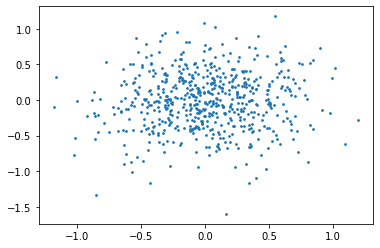

In [69]:
# Generate sampling points from a 2D Gaussian distribution
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(12021092)

def gen_2d_gaussian(mean, std, size=600):
    return np.random.multivariate_normal(mean, np.diag(std), size)

p = gen_2d_gaussian([0, 0], [0.16, 0.16])
plt.scatter(p[:, 0], p[:, 1], s=3)
plt.show()

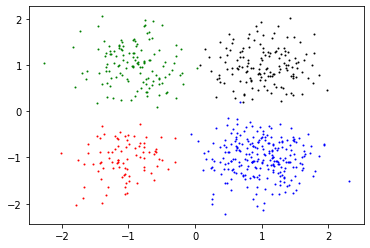

In [70]:
# Generate sampling points from a 2D Mixture of Gaussian (MOG) distribution
color = ['red', 'green', 'blue', 'black', 'yellow', 'gray', ]

def gen_2d_MoG(means, stds, size=600):
    n = len(means)
    sample = np.random.rand(n)
    sample = sample / sample.sum()
    sample = [int(i * size) for i in sample]
    return [gen_2d_gaussian(means[i], stds[i], sample[i]) for i in range(n)]

data = gen_2d_MoG(means=[[-1, -1], [-1, 1], [1, -1], [1, 1]], stds=[[0.16, 0.16]] * 4)
for i, p in enumerate(data):
    plt.scatter(p[:, 0], p[:, 1], s=1, color=color[i])
plt.show()

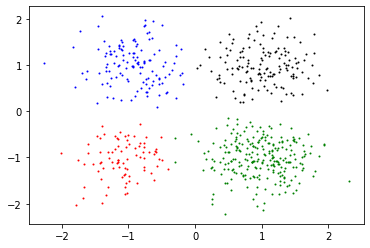

In [71]:
# Estimate of generated data via step2 by using the Mean-Shift method
# Plot the clustering results

def calc_distance(a, b):
    return np.linalg.norm(a - b)

class MeanShift(object):
    def __init__(self, kernel_h, stop_threshold, cluster_threshold):
        self.kernel_h = kernel_h
        self.stop_threshold = stop_threshold
        self.cluster_threshold = cluster_threshold
        
    @staticmethod
    def gaussian_kernel(x, h):
        return 1 / (h * np.sqrt(2 * np.pi)) * np.exp(-0.5 * np.linalg.norm(x / h) ** 2)
    
    def _shift(self, point, points):
        shift = np.zeros(2)
        scale = 0.
        for p in points:
            k = self.gaussian_kernel(p - point, self.kernel_h)
            shift += k * p
            scale += k
        shift /= scale
        return shift
    
    def _cluster(self, shift_points):
        points_n = shift_points.shape[0]
        
        fa = list(range(points_n))
        def _get_fa(fa, x): # 并查集
            return _get_fa(fa, fa[x]) if x != fa[x] else x
        
        for i in range(points_n - 1):
            # min_dist = 9999999
            for j in range(i + 1, points_n):
                dist = calc_distance(shift_points[i], shift_points[j])
                if dist < self.cluster_threshold:
                    fa_i = _get_fa(fa, i)
                    fa_j = _get_fa(fa, j)
                    fa[fa_i] = fa_j
                # if dist < min_dist:
                #     min_dist = dist
            # print("min:", min_dist)
        
        cluster = []
        fa_2_cluster_id = {}
        cluster_id = 0
        for i in range(points_n):
            f = _get_fa(fa, i)
            if f not in fa_2_cluster_id:
                cluster_id += 1
                fa_2_cluster_id[f] = cluster_id
            cluster.append(fa_2_cluster_id[f])
        return cluster
    
    def fit(self, points):
        points_n = points.shape[0]
        shifting = [True] * points_n
        shift_points = points.copy()
        while True:
            flag = False
            # max_dist = -1
            for i in range(points_n):
                if not shifting[i]:
                    continue
                flag = True
                shift_init = shift_points[i].copy()
                shift_points[i] = self._shift(shift_points[i], points)
                dist = calc_distance(shift_points[i], shift_init)
                shifting[i] = dist > self.stop_threshold
                # if dist > max_dist:
                #     max_dist = dist
            # print("max:", max_dist)
            if not flag:
                break
        return self._cluster(shift_points)
            
points = np.concatenate(data, axis=0)
ms = MeanShift(0.5, 1e-4, 1e-1)      
cluster = ms.fit(points)
for i, p in enumerate(points):
    plt.scatter(p[0], p[1], s=1, color=color[cluster[i] - 1])
plt.show()

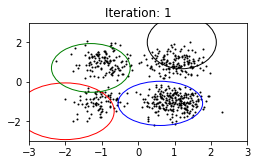

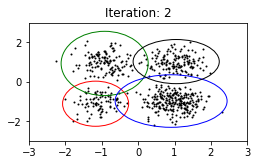

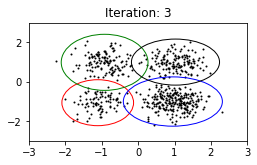

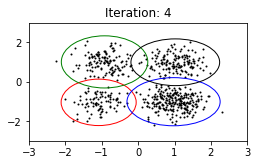

Iterations:  3


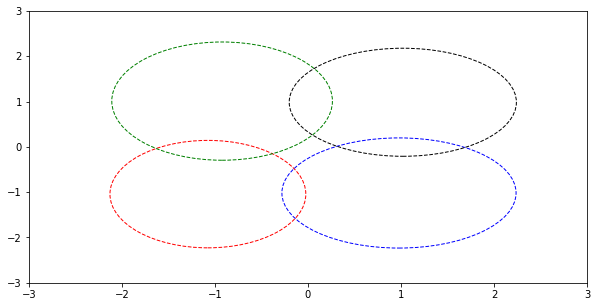

In [72]:
# Bonus - implement the EM algorithm of MoG in 2-D case
from matplotlib.patches import Ellipse


def E_step(data, ndim=2, p_sample=[0.5,0.5], mu=[[1,1],[3,3]], sigma=[[[9,0],[0,9]],[[9,0],[0,9]]]):
    n_samples = data.shape[0]
    p_estimate = np.zeros(shape=(ndim, n_samples))
    p_estimate_sum = np.zeros(shape=(1, n_samples))
    for j in range(n_samples):
        for i in range(ndim):
            p_gaussian = 1 / np.sqrt(((2 * np.pi) ** 2) * np.linalg.det(sigma[i])) * np.exp(-0.5 * np.dot(np.dot((data[j] - mu[i]), np.linalg.inv(sigma[i])), (data[j] - mu[i]).T))
            p_estimate[i][j] = p_sample[i] * p_gaussian
            p_estimate_sum[:,j] += p_estimate[i][j]
    p_estimate = p_estimate / p_estimate_sum
    
    return p_estimate
    
def M_step(data, p_estimate=None):
    
    n_samples = data.shape[0]
    ndim = p_estimate.shape[0]
    if p_estimate is None:
        p_estimate = np.zeros(shape=(ndim, n_samples))

    mu_estimate_sum = [0 for i in range(ndim)]
    mu_estimate = [0 for i in range(ndim)]
    sigma_estimate_sum = [0 for i in range(ndim)]
    sigma_estimate = [0 for i in range(ndim)]
    n_estimate = np.sum(p_estimate, axis=1)
    p_sample_estimate = n_estimate / n_samples # Mixture density we obtain from EM
    for i in range(ndim):
        for j in range(n_samples):
            mu_estimate_sum[i] += p_estimate[i][j] * data[j]
        mu_estimate[i] = mu_estimate_sum[i] / n_estimate[i] # Mu we obtain from EM
    for i in range(ndim):
        sigma_estimate_sum[i] = np.zeros(shape=(2,2))
        for j in range(n_samples):
            sigma_estimate_sum[i] += p_estimate[i][j] * np.dot((data[j] - mu_estimate[i]).reshape(-1,1), (data[j] - mu_estimate[i]).reshape(1,-1))
        sigma_estimate[i] = sigma_estimate_sum[i] / n_estimate[i]

    return p_sample_estimate, mu_estimate, sigma_estimate
    
def EM_iteration(data):
    Max_iter = 20
    epsilon = 1e-1
    
    ####  Initialization ####
    ndim = 4
    p_sample = [0.25, 0.25, 0.25, 0.25]
    mu = [[-2, -1.5], [-1.3, 0.7], [0.61, -1.1], [1.2, 2]]
    sigma = [
        [[0.2,0],[0,0.23]],
        [[0.13,0],[0,0.17]],
        [[0.15,0],[0,0.14]],
        [[0.1,0],[0,0.2]],
    ]
    ####
    
    n_samples = data.shape[0]
    p_estimate = np.zeros(shape=(ndim, n_samples))
    for i in range(Max_iter):
        ells = [Ellipse(
            xy=mu[j], 
            width=6 * np.sqrt(sigma[j][0][0]), 
            height=6 * np.sqrt(sigma[j][1][1])
        ) for j in range(ndim)]
        fig = plt.figure(1, figsize=(18,10))
        ax = fig.add_subplot(4, 4, i+1)
        ax.set_title('Iteration: {}'.format(i+1))
        for j,e in enumerate(ells):
            ax.add_artist(e)
            e.set_clip_box(ax.bbox)
            e.set_alpha(1)
            e.set_facecolor('none')
            e.set_edgecolor(color[j])
        ax.set_xlim(-3, 3)
        ax.set_ylim(-3, 3)
        plt.scatter(data[:,0], data[:,1], color='black', s=1)
        plt.show()
        # plt.savefig('EM_iterations_ndim4.png')
        
        p_estimate = E_step(data=data, ndim=ndim, p_sample=p_sample, mu=mu, sigma=sigma)
        old_mu = mu
        p_sample, mu, sigma = M_step(data=data, p_estimate=p_estimate)
        if(np.sum(np.sum(np.abs(np.array(old_mu) - np.array(mu)))) < epsilon):
            print ("Iterations: ", i)
            ells = [Ellipse(
                xy=mu[j], 
                width=6 * np.sqrt(sigma[j][0][0]), 
                height=6 * np.sqrt(sigma[j][1][1]), 
                linestyle='dashed'
            ) for j in range(ndim)]
            fig = plt.figure(0, figsize=(10,5))
            ax = fig.add_subplot(1,1,1)
            for j,e in enumerate(ells):
                ax.add_artist(e)
                e.set_clip_box(ax.bbox)
                e.set_alpha(1)
                e.set_facecolor('none')
                e.set_edgecolor(color[j])
            ax.set_xlim(-3, 3)
            ax.set_ylim(-3, 3)
            plt.show()
            # plt.savefig('MOG_Using_EM_ndim4.png')
            break
    
    return p_sample, mu, sigma

p_sample_estimate, mu, sigma = EM_iteration(points)